In [70]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from LoadData import load_data

In [71]:
sns.set() 
def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)

In [72]:
dirname = os.getcwd()
pth = os.path.join(dirname, 'CMAPSSData')

print('loading data...')
dc = load_data(pth)
print('done')

loading data...
done


In [73]:
# get the first data set training data
df = dc['FD_001']['df_train']

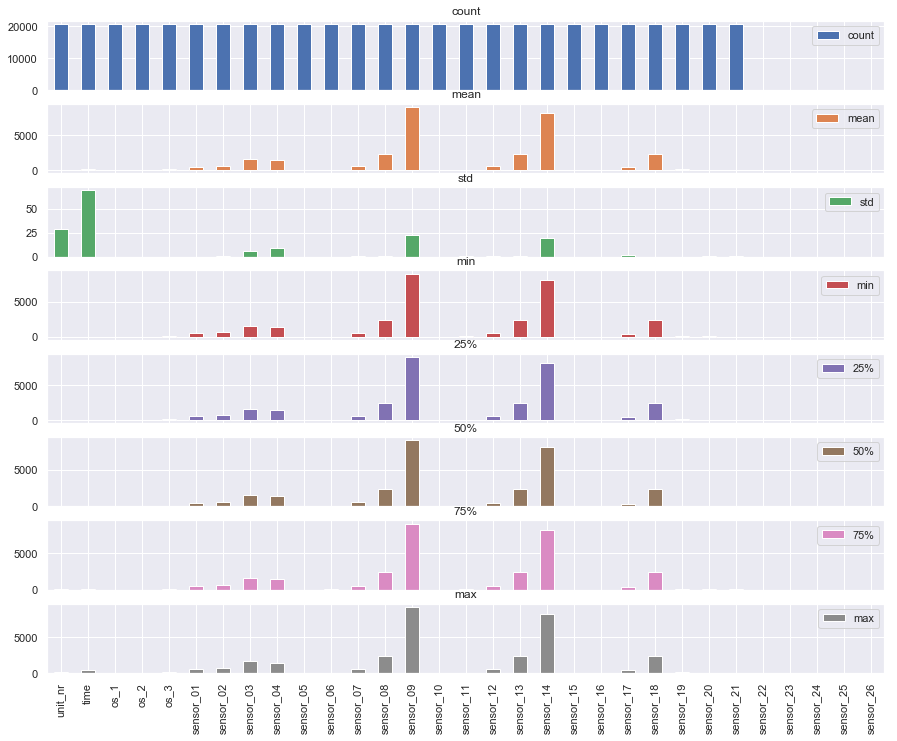

In [74]:
# plot an overview of whats going on in the columns
axes = df.describe().T.plot.bar(subplots=True, figsize=(15,12))

In [75]:
# Add RUL column to data:
# assume, that for the last measurement time RUL=0 (stopped measuring just before machine broke)

# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']

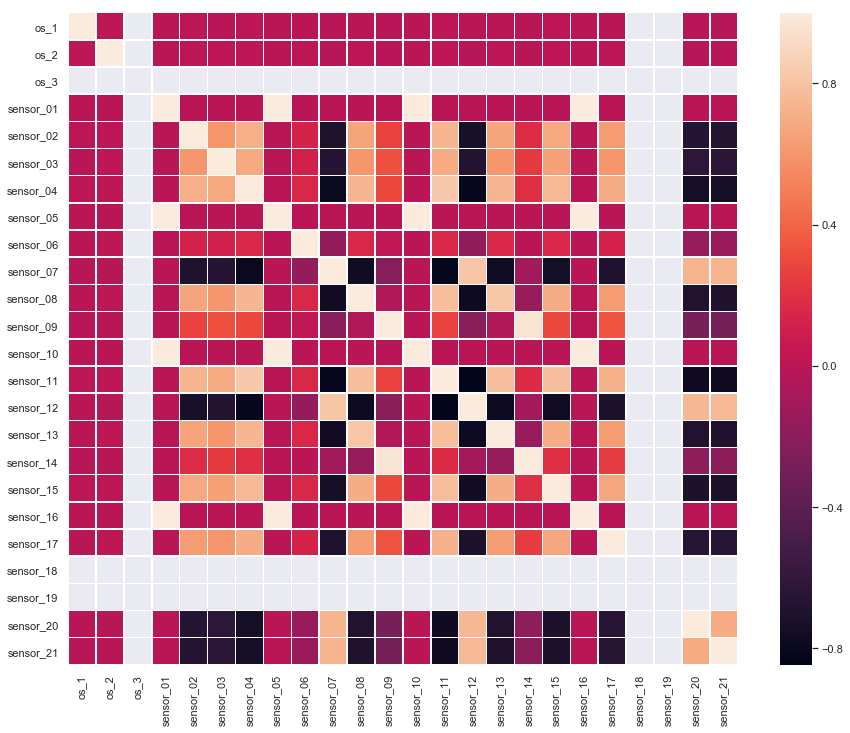

In [76]:
# plot correlation matrix

df_sub = df.copy()
del df_sub['unit_nr']
del df_sub['RUL']

df_sub.set_index('time', inplace=True)
df_sub.dropna(axis=1, how='all', inplace=True)

df_corr = df_sub.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(df_corr, linewidths=.5)

In [86]:


def exclude_trivial(df_sub):
    cols = []
    for col in df_sub.columns:
        if col == 'unit_nr':
            continue
        elif col == 'RUL':
            continue
        elif len(df_sub[col].unique()) <= 2:
            continue
        else:
            cols.append(col)
            
    return df_sub[cols].copy()

def get_data_non_trivial(df, unit_nr):
    df_sub = df.loc[df['unit_nr'] == unit_nr].copy()
    df_sub.set_index('time', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    
    df_sub = exclude_trivial(df_sub)
    return df_sub

def plot_ts_by_unit(df, unit_nr, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_nr)
    cols = df_sub.columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(15,12))
    
    for col, ax in zip(cols, axes):
        df_sub[col].plot(ax = ax)
        df_sub[col].rolling(wind_size).median().plot(ax = ax)
        df_sub[col].rolling(wind_size).mean().plot(style = '--', legend=True, ax = ax)
    fig.suptitle('unit NR: {}'.format(unit_nr))

def plot_hist_by_unit(df, unit_nr, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_nr)
    cols = df_sub.columns
    n_cols = min(len(cols), 5)
    n_rows = int(np.ceil(len(cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,12))
    axes = axes.flatten()
    for col, ax in zip(cols, axes):
        sns.distplot(df_sub[[col]], ax=ax, label=col)
        labels(col, "p", ax)
    fig.suptitle('unit NR: {}'.format(unit_nr))

In [87]:
mapper_by_length = sorted(mapper.items(), key=lambda kv: kv[1])
wind_size = 20

C:\Users\GLA_A\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


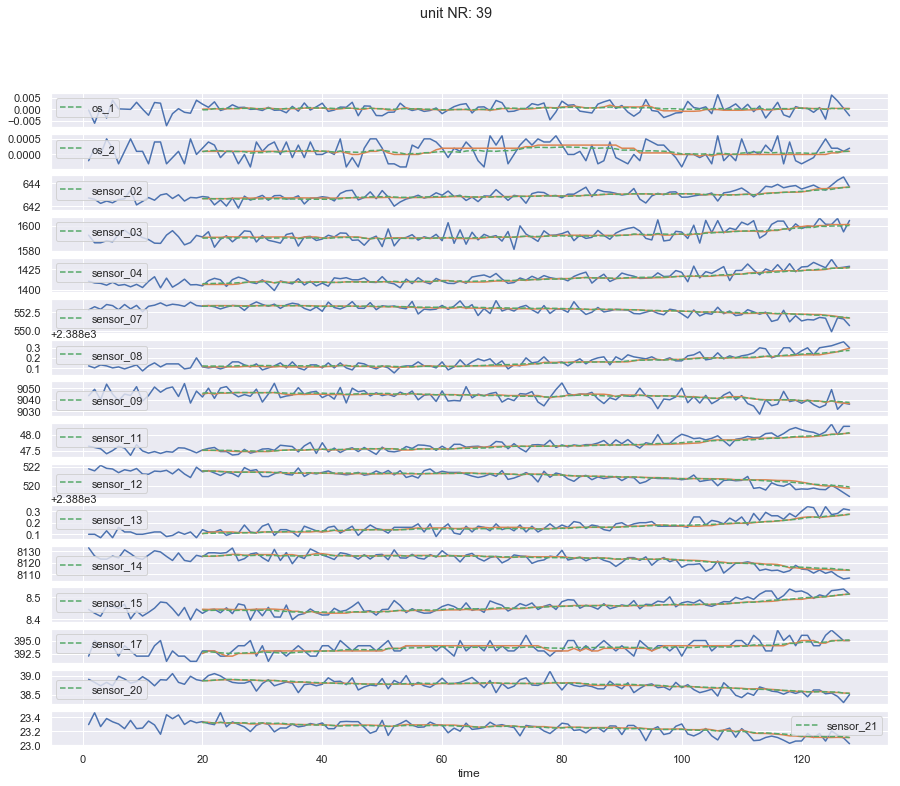

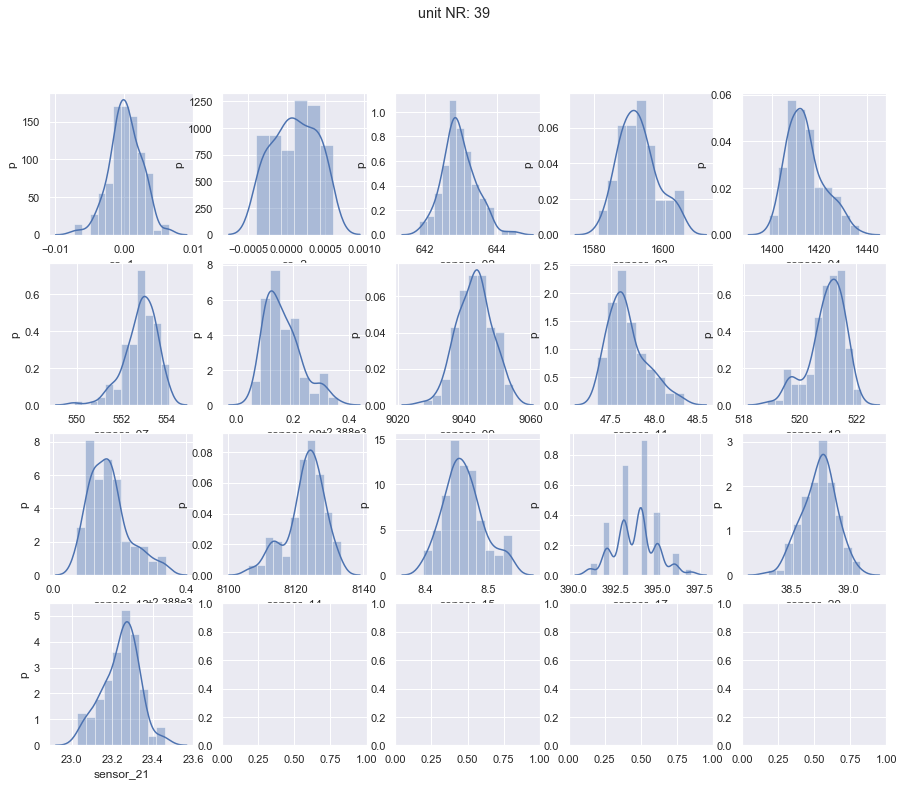

In [88]:
# plot shortes operating machine data
unit_to_plot = mapper_by_length[0][0]
plot_ts_by_unit(df, unit_to_plot, wind_size)
plot_hist_by_unit(df, unit_to_plot, wind_size)

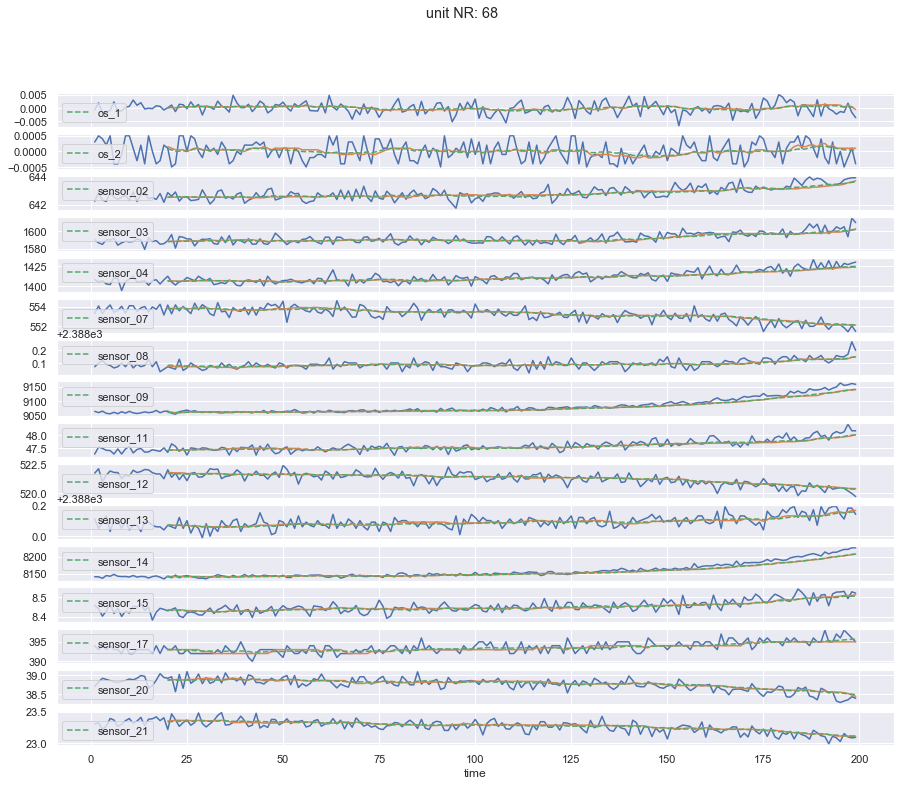

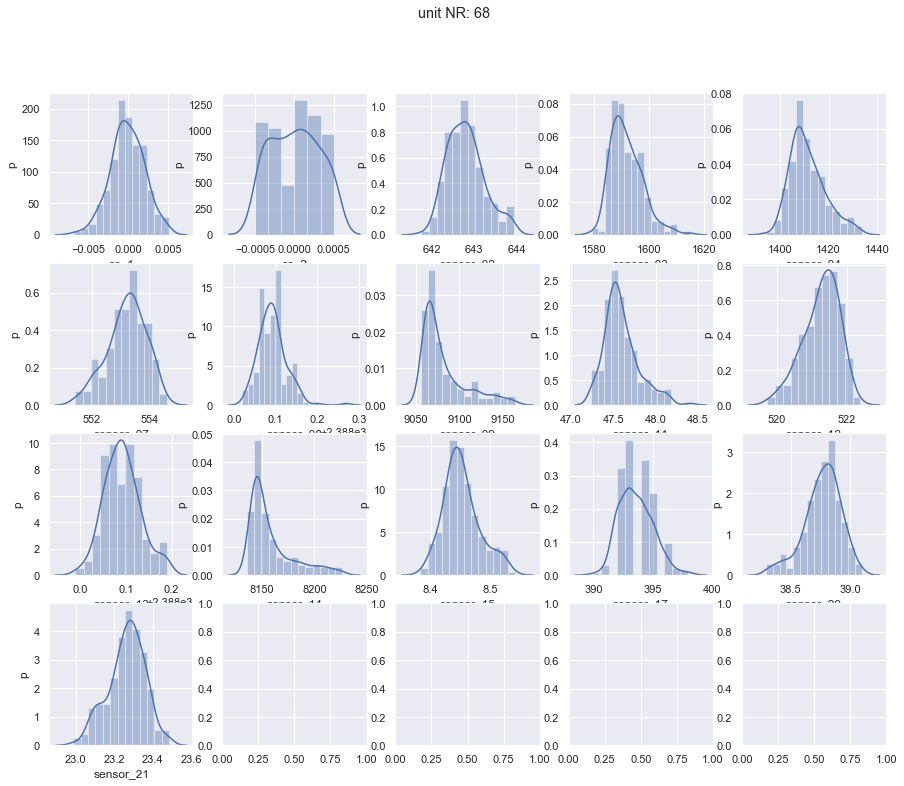

In [89]:
# plot medium time operating machine data
unit_to_plot = mapper_by_length[int(len(mapper)/2)][0]
plot_ts_by_unit(df, unit_to_plot, wind_size)
plot_hist_by_unit(df, unit_to_plot, wind_size)

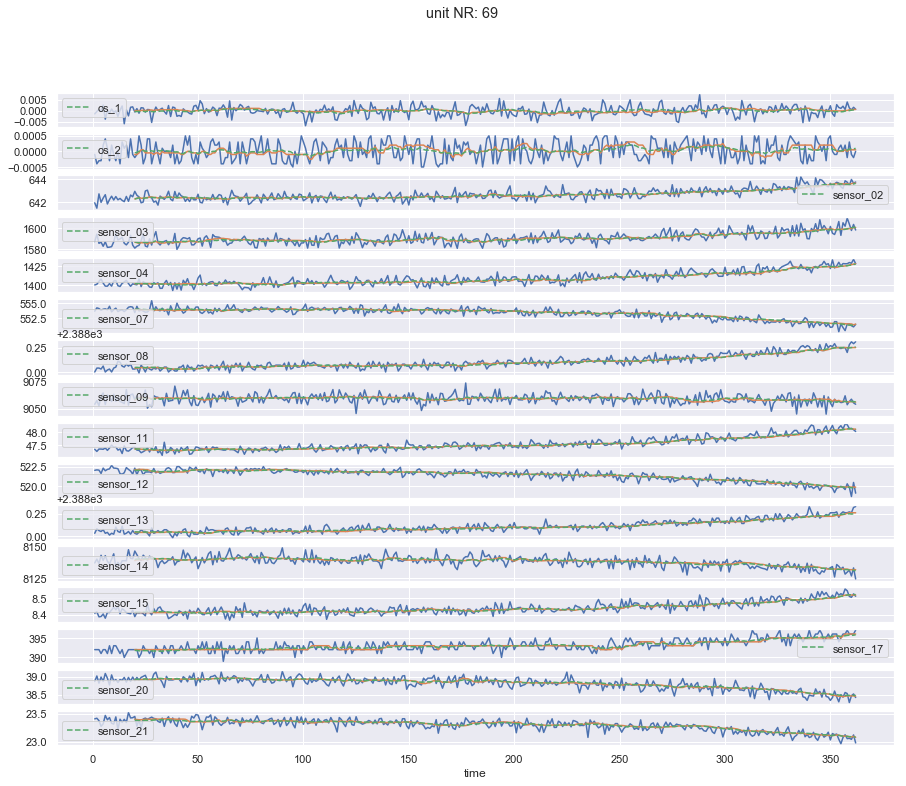

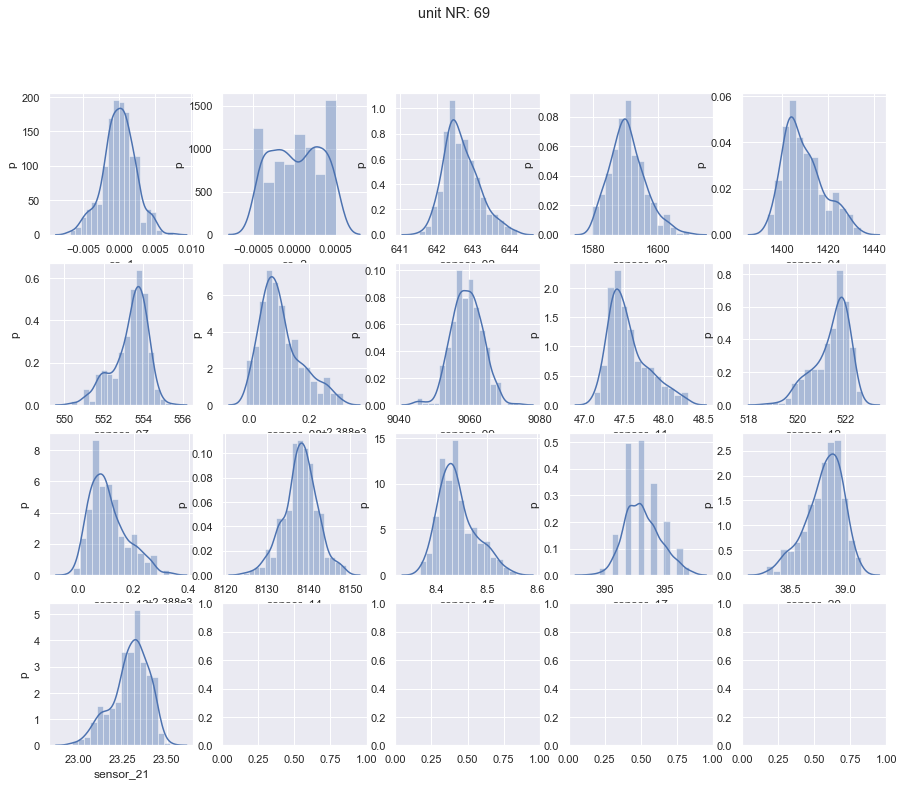

In [90]:
# plot longest operating machine data
unit_to_plot = mapper_by_length[-1][0]
plot_ts_by_unit(df, unit_to_plot, wind_size)
plot_hist_by_unit(df, unit_to_plot, wind_size)